# ZTF Pilot Survey Field Selection and Visualization

This notebook uses the [Rubin-sim](https://github.com/lsst/rubin_sim) package to generate the Rubin-LSST survey footprint, and the [Healpy](https://healpy.readthedocs.io/en/latest/) package for generating the sky coverage map.

Notebook developed by Zach Vanderbosch (Caltech)

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
import matplotlib.patheffects as pe

from tqdm import trange
from ztf_fields import show_fields
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
from astroplan import Observer
from astroplan import FixedTarget
from astroplan import AirmassConstraint
from astroplan import observability_table

# import rubin_sims maf packages 
# import rubin_sim.maf as maf
# from rubin_sim.data import get_baseline

# Plot appearance params
lw = 1.0
mpl.rcParams.update(
    {# Use mathtext, not LaTeX
    'text.usetex': False,
    'axes.formatter.use_mathtext': True,
    # Set the fonts
    'font.family': 'STIXGeneral',
    'mathtext.fontset': 'cm',
    # Use ASCII minus
    'axes.unicode_minus': False,
    # Set border width
    'axes.linewidth': lw,
    # X-tick Params
    'xtick.major.size': 6.0,
    'xtick.minor.size': 3.0,
    'xtick.major.width': lw,
    'xtick.minor.width': lw,
    # Y-tick params
    'ytick.major.size': 6.0,
    'ytick.minor.size': 3.0,
    'ytick.major.width': lw,
    'ytick.minor.width': lw,
    }
)

%matplotlib inline

In [2]:
# ZTF Field IDs for all 40 SCoPE-III fields
SCOPE_FIELDS = [
    295,296,297,298,
    422,423,424,425,
    486,487,488,489,
    561,562,563,564,
    681,682,683,684,
    698,699,700,701,
    716,717,718,719,
    776,777,778,779,
    840,841,842,843,
    851,852,853,854
]

# RA-Dec pairs for the COSMOS footprint
COSMOS_FOOTPRINT = [
    [150.7446, 2.8265],[150.3731, 2.8908],[150.3628, 2.8405],[150.0488, 2.8933],
    [150.0205, 2.7403],[149.9746, 2.7467],[149.9932, 2.8514],[149.7771, 2.8880],
    [149.7677, 2.8380],[149.5051, 2.8807],[149.4311, 2.4596],[149.4834, 2.4510],
    [149.4376, 2.1882],[149.4893, 2.1813],[149.4341, 1.8646],[149.4869, 1.8574],
    [149.4490, 1.6462],[149.5014, 1.6378],[149.4918, 1.5847],[149.6018, 1.5684],
    [149.6131, 1.6173],[149.8732, 1.5748],[149.8847, 1.6234],[150.1970, 1.5717],
    [150.2085, 1.6202],[150.4687, 1.5769],[150.4801, 1.6260],[150.7397, 1.5836],
    [150.7981, 1.8995],[150.7460, 1.9091],[150.7831, 2.1183],[150.7299, 2.1268],
    [150.7863, 2.4419],[150.7333, 2.4508],[150.7890, 2.7654],[150.7361, 2.7745],
    [150.7446, 2.8265]
]

# Load in ZTF Fields and Assess Observability

In [2]:
""" Load in ZTF Field Table """

list_dir = "./"
list_name = f"{list_dir}ZTF_Fields.txt"

field_list = pd.read_csv(
    list_name,
    delim_whitespace=True
)

""" Use Astroplan to get Field Observability """

# Observing date ranges
date_start = "2024-01-08T00:00:00.0"
date_end = "2024-01-10T16:00:00.0"
t_start = Time(date_start, format='isot', scale='utc')
t_end = Time(date_end, format='isot', scale='utc')

# Define location and constraints
palomar = Observer.at_site('palomar')
constraints = [
    AirmassConstraint(2.0)
]

# Set up list of Astroplan Targets
Nfields = len(field_list)
targets = []
for i in range(Nfields):

    field_id = field_list.ID.loc[i]
    field_coord = SkyCoord(
        ra=field_list.RA.loc[i]*u.deg,
        dec=field_list.Dec.loc[i]*u.deg,
        frame='icrs'
    )
    field = FixedTarget(
        name=f'field_{field_id:04d}', 
        coord=field_coord
    )
    targets.append(field)


# Get JD for each night 
jd = t_start.jd
jd_end = t_end.jd
times = []
while jd < jd_end:
    t = Time(jd, format='jd', scale='utc')
    times.append(t)
    jd += 1.0

mjd_times = [tt.mjd for tt in times]
date_times = [tt.isot.split("T")[0] for tt in times]

# Print out date range to confirm
num_nights = len(times)
print("      Date Range      ")
print("----------------------")
print(f"Start Date: {times[0].isot.split('T')[0]}")
print(f"  End Date: {times[-1].isot.split('T')[0]}")


# Initialize final table
print('\nDetermining field observability...')
target_observability = np.zeros((num_nights,Nfields))
night_durations = []
for i in trange(num_nights):

    # Define time range between astronomical twilight
    night = times[i]
    twilight_start = palomar.twilight_evening_astronomical(night)
    twilight_end = palomar.twilight_morning_astronomical(night)
    if twilight_end.jd < twilight_start.jd:
        twilight_end = palomar.twilight_morning_astronomical(night+1.0*u.day)
    night_duration = twilight_end - twilight_start
    night_duration = night_duration.to(u.hour).value
    night_durations.append(night_duration)
    time_range = [twilight_start,twilight_end]

    # Get observability for all fields on a given night
    observability = observability_table(
        constraints, 
        palomar, 
        targets, 
        time_range=time_range, 
        time_grid_resolution=0.02*u.hour
    ).to_pandas()

    # Add results to full numpy array
    target_observability[i,:] = observability['fraction of time observable'].values * night_duration

# Create pandas dataframe with full results
target_observability_df = pd.DataFrame(
    target_observability,
    columns=[f"field_{x:04d}" for x in field_list.ID.values]
)
target_observability_df.insert(0,'date',date_times)
target_observability_df.insert(1,'mjd',mjd_times)


# Figure out which fields are available for deep drilling
time_limit1 = 6.
time_limit2 = 8.
time_limit3 = 10.
good_fields1 = []
good_fields2 = []
good_fields3 = []
for i,field in enumerate(field_list.ID.values):
    
    colname = f'field_{field:04d}'
    thresh_idx1 = ((target_observability_df[colname] > time_limit1) & (target_observability_df[colname] < time_limit2))
    thresh_idx2 = ((target_observability_df[colname] > time_limit2) & (target_observability_df[colname] < time_limit3))
    thresh_idx3 = ((target_observability_df[colname] > time_limit3))
    gallat = field_list.GalLat.values[i]

    # Keep only primary grid fields that pass observability requirements
    if (sum(thresh_idx1)>=1) & (field < 1000) & (field > 244):
        good_fields1.append(field)
    elif (sum(thresh_idx2)>=1) & (field < 1000) & (field > 244):
        good_fields2.append(field)
    elif (sum(thresh_idx3)>=1) & (field < 1000) & (field > 244):
        good_fields3.append(field)
        
        
# Print out results
print(f'\n{len(good_fields1)} fields observable for 6-8 hours.')
print(f'{len(good_fields2)} fields observable for 8-10 hours.')
print(f'{len(good_fields3)} fields observable for 10+ hours.')

  0%|          | 0/3 [00:00<?, ?it/s]

      Date Range      
----------------------
Start Date: 2024-01-08
  End Date: 2024-01-10

Determining field observability...


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



94 fields observable for 6-8 hours.
60 fields observable for 8-10 hours.
23 fields observable for 10+ hours.


# Load in SDSS-V Plan

In [3]:
sdssplan = pd.read_csv("30112023_plan.csv")
sdssplan.rename(columns=lambda x: x.strip(),inplace=True)
sdss_unique_fields = sdssplan['field_id'].unique()

def get_sdss_field_coords(field_ra, field_dec):
    """
    Function that provides phi/theta coordinates
    for points along circumference of a circular
    field of view at center field_ra and field_dec
    and with 3.0 square deg. area (the SDSS-V FOV)
    """
    
    radius = np.sqrt(3.0/np.pi)
    coord = SkyCoord(
        ra=field_ra*u.deg, 
        dec=field_dec*u.deg, 
        frame='icrs'
    )

    circ = SphericalCircle(coord, radius*u.deg)
    circ_coord = SkyCoord(
        ra=circ.get_xy()[:,0]*u.deg, 
        dec=circ.get_xy()[:,1]*u.deg, 
        frame='icrs'
    )
    phi = circ_coord.ra.radian
    theta = -(circ_coord.dec.radian - np.pi/2)
    
    return theta, phi

FileNotFoundError: [Errno 2] No such file or directory: '30112023_plan.csv'

# Set Up and Calculate Rubin-LSST Metrics

In [7]:
nside = 128
outDir = '.'
opsdb = get_baseline()
opsim = os.path.basename(opsdb).replace('.db','')
metric = maf.metrics.CountMetric(col='observationStartMJD', metric_name='Nvisits')
slicer = maf.slicers.HealpixSlicer(nside=nside)
constraint = None

bundle = maf.MetricBundle(metric, slicer, constraint, run_name=opsim)
g = maf.MetricBundleGroup({'nvisits': bundle}, opsdb, out_dir=outDir)

# Calculate the metrics
g.run_all()

NameError: name 'get_baseline' is not defined

# Define Theta-Phi Coordinates of Galactic Plane and Center and COSMOS 
These coordinates are needed for Healpy plotting

In [18]:
# Galactic plane coordinates
plane_plus_minus = 20.0 # Degrees above and below plane to show dotted lines
gal_l = np.linspace(0.0,360,1000)
gal_b = np.zeros(len(gal_l))
gal_b_plus = np.ones(len(gal_l))*plane_plus_minus
gal_b_minus = -np.ones(len(gal_l))*plane_plus_minus
gc = SkyCoord(l=gal_l*u.deg,b=gal_b*u.deg,frame='galactic')
gc_plus = SkyCoord(l=gal_l*u.deg,b=gal_b_plus*u.deg,frame='galactic')
gc_minus = SkyCoord(l=gal_l*u.deg,b=gal_b_minus*u.deg,frame='galactic')

gal_ra = gc.icrs.ra.wrap_at(180 * u.deg).radian
gal_dec = gc.icrs.dec.radian
gal_dec = gal_dec[np.argsort(gal_ra)]
gal_ra = gal_ra[np.argsort(gal_ra)]
gal_phi = gc.icrs.ra.radian
gal_theta = -(gc.icrs.dec.radian - np.pi/2)

gal_ra_plus = gc_plus.icrs.ra.wrap_at(180 * u.deg).radian
gal_dec_plus = gc_plus.icrs.dec.radian
gal_dec_plus = gal_dec_plus[np.argsort(gal_ra_plus)]
gal_ra_plus = gal_ra_plus[np.argsort(gal_ra_plus)]
gal_phi_plus = gc_plus.icrs.ra.radian
gal_theta_plus = -(gc_plus.icrs.dec.radian - np.pi/2)

gal_ra_minus = gc_minus.icrs.ra.wrap_at(180 * u.deg).radian
gal_dec_minus = gc_minus.icrs.dec.radian
gal_dec_minus = gal_dec_minus[np.argsort(gal_ra_minus)]
gal_ra_minus = gal_ra_minus[np.argsort(gal_ra_minus)]
gal_phi_minus = gc_minus.icrs.ra.radian
gal_theta_minus = -(gc_minus.icrs.dec.radian - np.pi/2)

# Galactic Center coordinates
sag = SkyCoord("17h45m40.04s −29d00m28.1s",frame='icrs')
sag_ra = sag.ra.wrap_at(180 * u.deg).radian
sag_dec = sag.dec.radian
sag_phi = sag.ra.radian
sag_theta = -(sag.dec.radian - np.pi/2)

# COSMOS coordinates
cosmos_ra = [x[0] for x in COSMOS_FOOTPRINT]
cosmos_dec = [x[1] for x in COSMOS_FOOTPRINT]
cosmos_coord = SkyCoord(ra=cosmos_ra*u.deg,dec=cosmos_dec*u.deg,frame='icrs')
cosmos_phi = cosmos_coord.ra.radian
cosmos_theta = -(cosmos_coord.dec.radian - np.pi/2)

# Plot Sky Coverage

/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

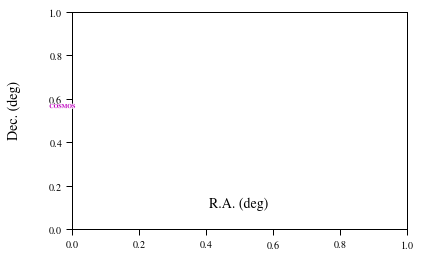

In [9]:
# The ZTF field fill colors, must be 'None', only edge colors work
all_field_colors = ['None']*len(field_list)

# I needed a copy of the skymaps with regions labelled.
figformat = 'png'
# ph = maf.PlotHandler(savefig=False, fig_format=figformat, thumbnail=False, out_dir=outDir)
# ph.set_metric_bundles([bundle])
# ph.plot(
#     plot_func=maf.plots.HealpixSkyMap(),
#     plot_dicts={
#         'color_min':  0, 
#         'color_max':  1000, 
#         'figsize': (8, 7),  
#         'nTicks': 7,
#         'labelsize': 'x-large', 
#         'fontsize':'x-large', 
#         'xlabel': "Rubin-LSST Visits after 10 Years",
#         'cmap': 'viridis',
#         'bgcolor': 'w',
#         'badcolor': 'gainsboro',
#         'noGraticule': True,
#         'xsize': 2000
#     }
# )

# Overplot sources and galacitc plane
hp.projplot(gal_theta, gal_phi, c='k',lw=1.5, alpha=1, zorder=1)
hp.projplot(gal_theta_plus, gal_phi_plus, c='k',lw=1.0, alpha=1, zorder=1, ls='--')
hp.projplot(gal_theta_minus, gal_phi_minus, c='k',lw=1.0, alpha=1, zorder=1, ls='--')
hp.projscatter(sag_theta, sag_phi, fc='k',marker='X',ec='None',alpha=1, s=100, lw=1.5, zorder=1)


# Add axis labels
plt.figtext(0.51, 0.20, r'R.A. (deg)', fontsize=14, color='k', ha='center')
plt.figtext(-0.01, 0.54, r'Dec. (deg)', fontsize=14, color='k', ha='center',va='center',rotation=90)


# Add ZTF fields
ax = plt.gca()
show_fields(
    ax, good_fields1, 'equatorial', all_field_colors, edgecolor='mistyrose', 
    lw=0.5, linestyle='-', fontsize=6, fontcolor='w', fontalpha=1, 
    alpha=1, zorder=2, hpy=True, show_text=False)
show_fields(
    ax, good_fields2, 'equatorial', all_field_colors, edgecolor='coral', 
    lw=0.5, linestyle='-', fontsize=6, fontcolor='w', fontalpha=1, 
    alpha=1, zorder=2, hpy=True, show_text=False)
show_fields(
    ax, good_fields3, 'equatorial', all_field_colors, edgecolor='darkred', 
    lw=1, linestyle='-', fontsize=6, fontcolor='w', fontalpha=1, 
    alpha=1, zorder=2, hpy=True, show_text=False)
show_fields(
    ax, SCOPE_FIELDS, 'equatorial', all_field_colors, edgecolor='b', 
    lw=1.25, linestyle=':', fontsize=6, fontcolor='magenta', fontalpha=1, 
    alpha=1, zorder=2, hpy=True, show_text=True)


# Show COSMOS Field
hp.projplot(cosmos_theta, cosmos_phi, c='m',lw=0.5, alpha=1, ls='-')
plt.figtext(
    0.072, 0.546, 'COSMOS', fontsize=6, color='m',fontweight='bold',
    path_effects=[pe.withStroke(linewidth=1, foreground="w")]
)

# Add SDSS-V Planned Fields
# for sdssfield in sdss_unique_fields:

#     plan_entry = sdssplan.loc[sdssplan.field_id == sdssfield]
#     field_ra = plan_entry.racen.iloc[0]
#     field_dec = plan_entry.deccen.iloc[0]

#     field_theta, field_phi = get_sdss_field_coords(field_ra, field_dec)
#     hp.projplot(field_theta, field_phi, c='k',lw=1.50, alpha=1, zorder=4, ls='-')
#     hp.projplot(field_theta, field_phi, c='w',lw=0.75, alpha=1, zorder=4, ls='-')


# Add title
plt.title(f'', fontsize='xx-large', fontweight='normal')

# Add graticule
hp.graticule(c='silver',zorder=0, dpar=30, dmer=30)

# Save the figure
plt.savefig('Pilot_Fields_selection.png', 
    facecolor='w', edgecolor='w', bbox_inches='tight', dpi=500, format=figformat)


/Users/viraj/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


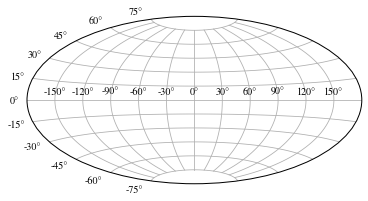

In [11]:
ax = plt.subplot(projection="aitoff")
ax.grid()
show_fields(ax=ax,fields=[526], system='equatorial', colors='blue', edgecolor='mistyrose', 
    lw=0.5, linestyle='-', fontsize=6, fontcolor='w', fontalpha=1, 
    alpha=1, zorder=2, hpy=True, show_text=False)

In [13]:
import healpy as hp

In [28]:
NSIDE = 32
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 32 is 1.8 deg


12288


/Users/viraj/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/viraj/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/viraj/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This

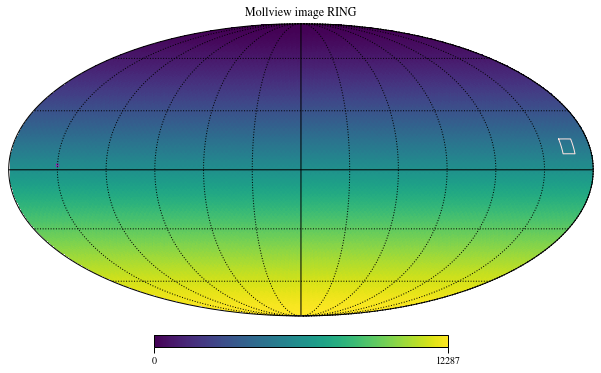

In [27]:
hp.mollview(m, title="Mollview image RING")
hp.projplot(cosmos_theta, cosmos_phi, c='m',lw=0.5, alpha=1, ls='-')
hp.graticule()

ax = plt.gca()
show_fields(
    ax, [526], 'equatorial', 'black', edgecolor='mistyrose', 
    lw=1, linestyle='-', fontsize=6, fontcolor='w', fontalpha=1, 
    alpha=1, zorder=2, hpy=True, show_text=False)